Purpose of this notebook: 
* reads and summarizes the outputs from projections and smoothing
* creates LaTeX table for the paper 


In [534]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [248]:
%autoreload 2
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = (10, 8)
import pprint

In [216]:
from __future__ import print_function
from astropy.stats import biweight_location
import pandas as pd
import h5py
import sys
sys.path.append("../")
import extract_catalog as ec
import get_DM_centroids as getDM
# import seaborn as sns
import compute_distance as compDist
import plot_cred_int as plotCI
import plot_gal_prop as plotgal
import get_KDE

In [217]:
data_path = "../../data/test_results/"

# read in files 

In [218]:
clstNo = 43
date_stamp = '06_17_16'

DM_fhats = \
    h5py.File(data_path +
              "DM_fhat_clst{0}_{1}.h5".format(
            clstNo, date_stamp), 'r')
star_fhats = \
    h5py.File(data_path +
              "stars_fhat_clst{0}_{1}.h5".format(
            clstNo, date_stamp), 'r')
main_FOF_h5 = h5py.File(
        "../../data/" +
        "Illustris-1_fof_subhalo_myCompleteHaloCatalog_00135" +
        ".hdf5", "r")

In [219]:
star_no_dens_fhat = \
    h5py.File("../../data/test_results/" + 
              "stars_fhat_clst_no_density_43_06_25_16.h5")

## columns in my uber dataframe (projection independent part)
| ClstNo | $m_{200c}$ | richness | relaxedness0| relaxedness1 |  


## projection dependent part 
| ClstNo | kernel_width | $\Delta s_{BCG}$ | $\Delta s_{KDE}$ | $\zeta$ | $\Delta s_{SA}$ | $\Delta s_{C}$ |  projection | total_peaks_dens | 

ClstNo is retained to match and join the two sets of `df`

# gather the projection dependent part of the `uber_df`

In [557]:
stat_key_dict = {
    'BCG': r"$\Delta s_{\rm BCG}$", 
    'shrink_cent': r"$\Delta s_{\rm shrink}$'", 
    'KDE': r"$\Delta s_{\rm KDE}$'",
    'no_peak': r"$\Delta s_{\rm num KDE}$"
    }

The Uber DF contains offsets from between the galaxy KDE peak and the corresponding DM peaks

In [235]:
uber_df1 = pd.read_hdf("../../data/uber_df_06_17_16.h5", 'df')
uber_df2 = pd.read_hdf("../../data/uber_df_06_21_16.h5", 'df')
no_dens_df = pd.read_hdf('../../data/no_dens_dist_df.h5', 'df')
uber_df = pd.concat([uber_df1, uber_df2])

In [637]:
uber_df.keys()

Index([u'BCG', u'Delta_x_BCG', u'Delta_x_centroid', u'Delta_x_shrink_cent', u'Delta_y_BCG', u'Delta_y_centroid', u'Delta_y_shrink_cent', u'centroid', u'shrink_cent', u'peak_id', u'KDE', u'Delta_x_KDE', u'Delta_y_KDE', u'total_peaks_dens', u'bin_width'], dtype='object')

# make plots

In [497]:
dom_peak_gpby = uber_df.groupby(['peak_id', 'bin_width'])
dom_peak_df_25 = dom_peak_gpby.get_group((0, 25.0))
dom_peak_df_25.index = range(dom_peak_df_25.shape[0])
sum_stat_dom_peak_df = pd.concat([dom_peak_df_25, no_dens_df], 
                                 axis=1)
sum_stat_dom_peak_df.columns = \
    [u'BCG', u'Delta_x_BCG', u'Delta_x_centroid', 
     u'Delta_x_shrink_cent', u'Delta_y_BCG', 
     u'Delta_y_centroid', u'Delta_y_shrink_cent', 
     u'centroid', u'shrink_cent', u'peak_id', 
     u'KDE', u'Delta_x_KDE', u'Delta_y_KDE', 
     u'total_peaks_dens', 
     u'bin_width', 
     u'Delta_x_no_peak', 
     u'Delta_y_no_peak', 
     u'no_peak']

In [607]:
sum_stat_dom_peak_df.to_hdf('../../data/sum_stat_dom_peak_df.h5', 'df')

/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  warnings.warn(ws, PerformanceWarning)
/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  warnings.warn(ws, PerformanceWarning)


In [473]:
percentiles = {68L: int(.68 * sum_stat_dom_peak_df.shape[0]), 
               95L: int(.95 * sum_stat_dom_peak_df.shape[0]), 
               99L: int(.99 * sum_stat_dom_peak_df.shape[0])}

In [505]:
def compute_mag_p_value_intervals(df, stat_key, percentiles):
    sorted_stat = np.argsort(df[stat_key])
    return {k: df[stat_key][sorted_stat[v]]
               for k, v in percentiles.iteritems()}

In [559]:
p_value_intervals = {key: compute_p_value_intervals(
                          sum_stat_dom_peak_df, key, percentiles)
                     for key in stat_key_dict}

In [515]:
oneD_sum_stat_p_value_intervals = [
    pd.DataFrame(df, index=[key]) 
    for key, df in p_value_intervals.iteritems()]

In [516]:
pd.concat(oneD_sum_stat_p_value_intervals)

,68,95,99
KDE,40.225566,107.894565,152.025066
BCG,4.914816,311.877084,1661.338151
no_peak,125.451396,457.594718,904.985188
shrink_cent,119.151872,376.907396,864.545211


# make p-value level plots 

In [545]:
asym_sum_stat_df.transpose

,loc,low68,low95,up68,up95
BCG,2.830913,1.170400,0.278709,10.301319,1172.995385
shrink_cent,63.219417,13.256557,-6.674870,228.776754,555.060734
KDE,27.259697,10.796566,3.095278,64.124059,131.054541
no_peak,90.691058,42.212232,14.315034,183.553616,679.474348


# the 1D magnitude of the offsets by taking Euclidean distance

This gives a very asymmetrical distribution with discontinuity at $\Delta s = 0$. 

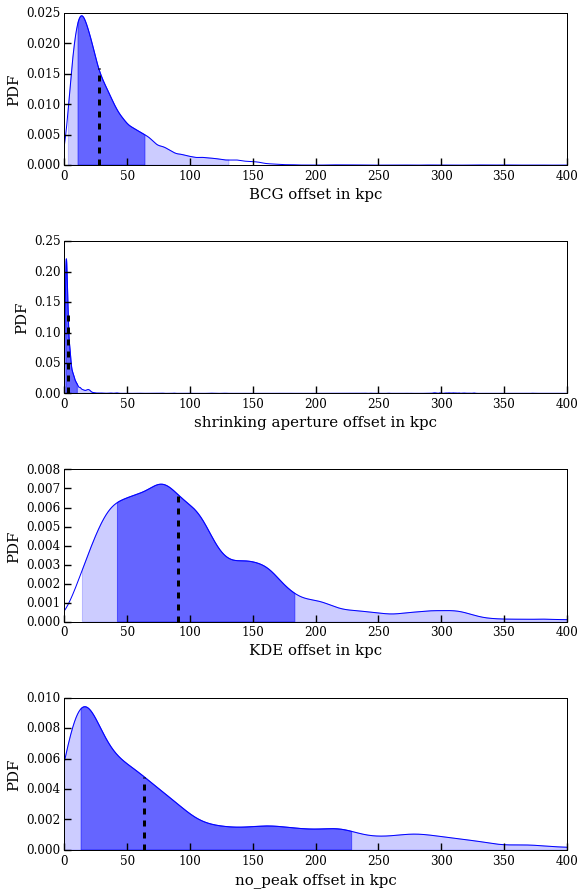

In [650]:
sum_stat_df_list = []
plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(4, 1)
gs.update(hspace=0.5, wspace=0.3)
gs.set_width_ratios([1., 1.])

ax_lists = [[plt.subplot(gs[row, col]) for col in range(1)]
            for row in range(4)] 

offset_labels = ['BCG', 'shrinking aperture', 'KDE', 'no_peak']
title_on = False
for i, stat in enumerate(stat_key_dict.keys()):
    ax1 = ax_lists[i][0]
    sum_stat1 = plotCI.CI_loc_plot(np.array(sum_stat_dom_peak_df[stat]), 
                                   ax=ax1)
    ax1.set_xlim(0, 400)
  
    ax1.set_ylabel('PDF')
    ax1.set_xlabel(offset_labels[i] + ' offset in kpc')
    ax1.tick_params(labeltop='off', labelright='off')
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    if title_on:
        ax1.set_title(stat + 
                 " loc={0:.0f} $\pm$ {1:.0f}, {2:.0f}, {3:.0f}, {4:.0f}".format(
                 sum_stat1['loc'], sum_stat1['low68'], sum_stat1['up68'], 
                 sum_stat1['low95'], sum_stat1['up95'])
                )
    sum_stat_df_list.append(pd.DataFrame(sum_stat1, index=[stat]))
    ax.tick_params(labeltop='off', labelright='off')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('../../paper/figures/finalized/Fig9_offset_distribution.png',
            bbox_inches='tight')
asym_sum_stat_df = pd.concat(sum_stat_df_list)

for final results there will be several tables:
* 

In [578]:
sym_sum_stat_df.keys()

Index([u'Delta_x_BCG', u'Delta_x_KDE', u'Delta_x_no_peak', u'Delta_x_shrink_cent'], dtype='object')

In [611]:
one_direction_stat_dict = {
    "Delta_y_BCG": r"$\Delta y_{\rm BCG}$",
    "Delta_y_shrink_cent": r"$\Delta y_{\rm shrink}'$",
    "Delta_y_KDE": r"$\Delta y_{\rm KDE}'$",
    "Delta_y_no_peak": r"$\Delta y_{\rm num. dens}$",
}

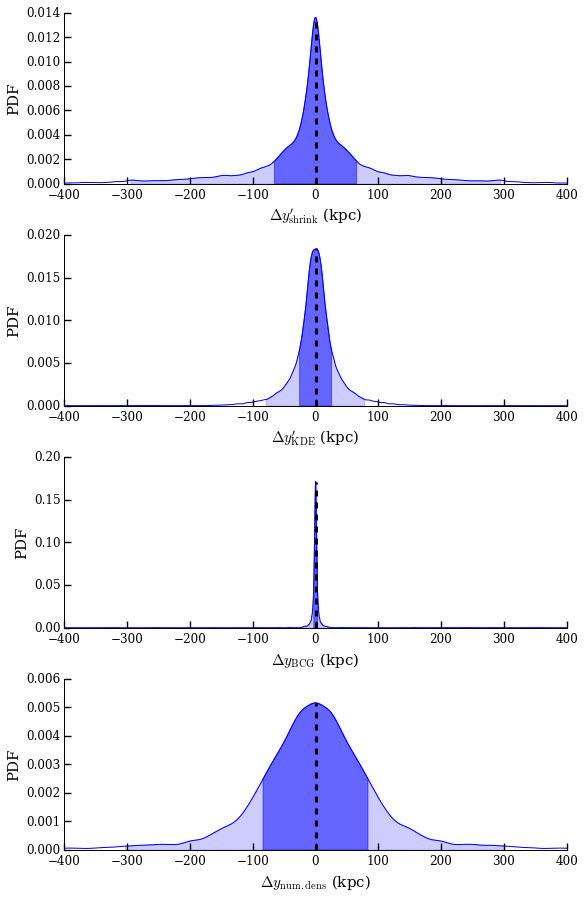

In [651]:
sum_stat_df_list = []
plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(4, 1)
gs.update(hspace=0.3)
gs.set_width_ratios([1., 1.])

ax_lists = [[plt.subplot(gs[row, col]) for col in range(1)]
            for row in range(4)] 

lvl = [68., 95., 99.]
sym_sum_stat_df_dict = {}

for i, stat in enumerate(one_direction_stat_dict):
    ax = ax_lists[i][0]
    fig = plt.figure()
    sym_sum_stat_df_dict[stat] = \
        plotCI.CI_loc_plot(np.array(sum_stat_dom_peak_df[stat]), 
                           ax=ax, lvls=lvl)
    ax.set_xlim(-400, 400)
    ax.set_xlabel(one_direction_stat_dict[stat] + ' (kpc)')
    ax.set_ylabel('PDF')
    ax.tick_params(labeltop='off', labelright='off')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig('../../paper/figures/finalized/fig5_symmetrical_1D_pdf.png',
            bbox_inches='tight'
            )
plt.show()

In [613]:
sym_sum_stat_df = pd.DataFrame(sym_sum_stat_df_dict)

In [614]:
dom_peak_df_25.index = no_dens_df.index

In [627]:
sym_sum_stat_df.columns = \
   [one_direction_stat_dict[k] for k in sym_sum_stat_df.keys()]

In [633]:
sym_sum_stat_df.index = [
    u'location', 
    u'lower 68\%', 
    u'lower 95\%', 
    u'lower 99\%', 
    u'upper 68\%', 
    u'upper 95\%', 
    u'upper 99\%']

In [640]:
with open('../../paper/p_val_table.tex', 'w') as f:
    f.write(sym_sum_stat_df.transpose().to_latex(
            float_format=str_formatter, escape=False))

In [641]:
!cat ../../paper/p_val_table.tex

\begin{tabular}{lrrrrrrr}
\toprule
{} &  location &  lower 68\% &  lower 95\% &  lower 99\% &  upper 68\% &  upper 95\% &  upper 99\% \\
\midrule
$\Delta y_{\rm BCG}$       &         0 &          -3 &         -22 &        -496 &           3 &         456 &        1449 \\
$\Delta y_{\rm KDE}'$      &         0 &         -25 &         -79 &        -127 &          25 &          79 &         126 \\
$\Delta y_{\rm num. dens}$ &        -0 &         -84 &        -303 &        -693 &          84 &         302 &         691 \\
$\Delta y_{\rm shrink}'$   &        -0 &         -65 &        -295 &        -652 &          65 &         295 &         655 \\
\bottomrule
\end{tabular}


# write out results in df to latex table

In [576]:
from collections import OrderedDict
key_mapping = OrderedDict([
 (u'BCG', r"$|\Delta s_{\rm BCG}|$"), 
 (u'Delta_x_BCG', r"$\Delta x_{\rm BCG}$"),
 (u'Delta_y_BCG', r"$\Delta y_{\rm BCG}$"), 
 (u'centroid', r"$|\Delta s_{\rm centroid}'|$"), 
 (u'Delta_x_centroid', r"$\Delta x_{\rm centroid}'$"), 
 (u'Delta_y_centroid', r"$\Delta y_{\rm centroid}'$"), 
 (u'shrink_cent', r"$|\Delta s_{\rm shrink}'|$"),
 (u'Delta_x_shrink_cent', r"$\Delta x_{\rm shrink}'$"), 
 (u'Delta_y_shrink_cent', r"$\Delta y_{\rm shrink}'$"),
 (u'KDE', r"$|\Delta s_{\rm KDE}'|$"), 
 (u'Delta_x_KDE', r"$\Delta x_{\rm KDE}'$"), 
 (u'Delta_y_KDE', r"$\Delta y_{\rm KDE}'$"), 
 (u'no_dens_dist', r"$\Delta s_{\rm num. KDE}$"),
 (u'Delta_no_peak_x', r"$\Delta x_{\rm num. KDE}$"), 
 (u'Delta_no_peak_y', r"$\Delta y_{\rm num. KDE}$"),
 # ( u'total_peaks_dens', r"$\nu$")
]
)

In [569]:
sum_stat_all_peak_df = all_peak_df[key_mapping.keys()].describe()

In [570]:
sum_stat_all_peak_df.columns = key_mapping.values()

In [573]:
sum_stat_all_peak_df = sum_stat_all_peak_df.transpose()[
    [u'mean', u'std', u'min', u'25%', u'50%', u'75%', u'max']]

In [574]:
def str_formatter(float_str):
    return '{0:.0f}'.format(float_str)

In [575]:
with open("../../paper/full_sum_stat_table.tex", "w") as f:
    f.write(sum_stat_all_peak_df.to_latex(
            escape=False, float_format=str_formatter))

In [345]:
!cat ../../paper/full_sum_stat_table.tex

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &  mean &  std &   min &  25% &  50% &  75% &  max \\
\midrule
$\Delta s_{\rm BCG}$       &  33024 &    69 &  294 &     0 &    2 &    3 &    7 & 2335 \\
$\Delta x_{\rm BCG}$       &  33024 &   -14 &  226 & -2331 &   -2 &   -0 &    1 & 2327 \\
$\Delta y_{\rm BCG}$       &  33024 &    23 &  197 & -1980 &   -2 &    0 &    2 & 2332 \\
$\Delta s_{\rm centroid}$' &  33024 &   261 &  209 &     2 &  114 &  202 &  317 & 1103 \\
$\Delta x_{\rm centroid}$' &  33024 &   -42 &  224 & -1022 & -164 &  -37 &   66 & 1101 \\
$\Delta y_{\rm centroid}$' &  33024 &     0 &  244 & -1102 & -111 &   -0 &  111 & 1100 \\
$\Delta s_{\rm shrink}$'   &  33024 &   118 &  156 &     0 &   21 &   60 &  165 & 1454 \\
$\Delta x_{\rm shrink}$'   &  33024 &    -7 &  131 & -1089 &  -39 &   -3 &   23 &  969 \\
$\Delta y_{\rm shrink}$'   &  33024 &     0 &  145 & -1091 &  -32 &    0 &   32 & 1109 \\

$\Delta x_{\rm KDE}$'      &  33024 &    -2 &   35 &  -330 &  -17 &   -2 &   1

# gather the projection independent part of our uber dataframe

In [644]:
uber_df = compDist.construct_uber_result_df(
    star_fhats, DM_fhats, main_FOF_h5
)

In [645]:
uber_df

,clstNo,M200C,richness
0,0,16354.563477,483
1,1,15690.170898,338
2,2,15334.584961,267
3,3,8242.116211,343
4,4,11930.483398,213
5,5,8998.541992,212
6,6,9581.916992,225
7,7,3094.354736,230
8,8,8251.128906,148
9,9,7854.237305,187


# check if things look consistent with 2D vis

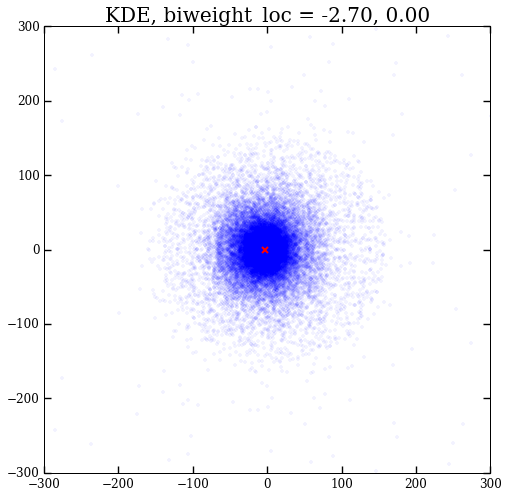

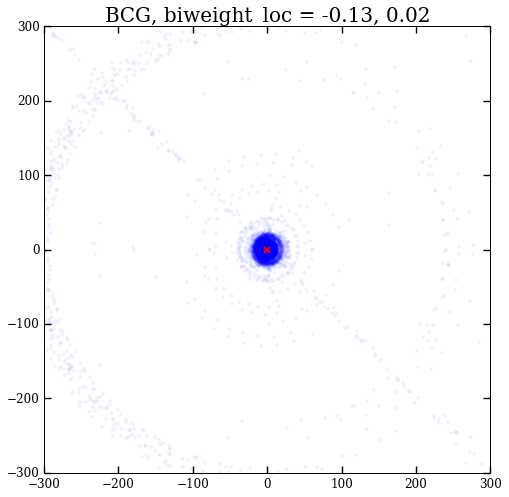

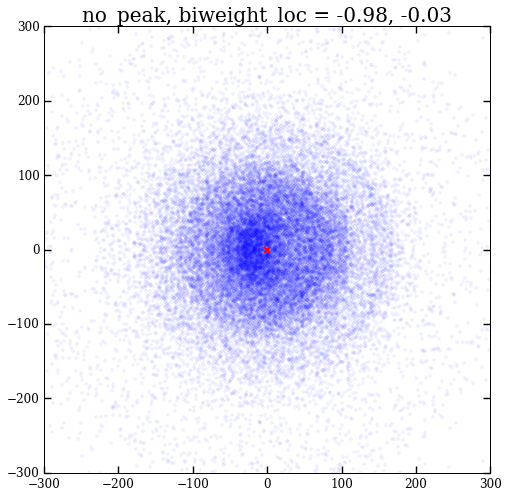

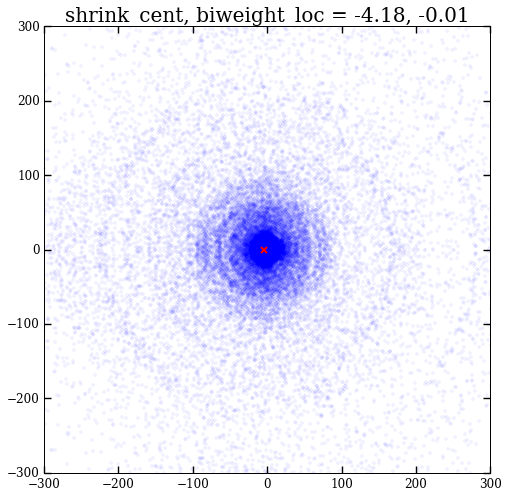

In [643]:
## This is for DOMINANT PEAKS only
for i, key in enumerate(stat_key) :
    plt.axes().set_aspect('equal')
    
    plt.plot(
        np.array(sum_stat_dom_peak_df['Delta_x_' + key]), 
        np.array(sum_stat_dom_peak_df['Delta_y_' + key]),
        'b.', alpha=0.05
        )
    biweight_loc = (
        biweight_location(sum_stat_dom_peak_df['Delta_x_' + key]), 
        biweight_location(sum_stat_dom_peak_df['Delta_y_' + key]))
    plt.plot(biweight_loc[0], biweight_loc[1],
             'rx', mew=2.)
    
    plt.xlim(-300, 300)
    plt.ylim(-300, 300)
    plt.title(key + ', biweight_loc = {0:.2f}, {1:.2f}'.format(
            *biweight_loc))
    
    plt.show()
    plt.clf()